# Dataset Yeast

## Übersicht


## Imports

In [1]:
import os
import sys
import shutil

sys.path.append('../src')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt

from yellowbrick.features import ParallelCoordinates
from yellowbrick.features import Rank1D, Rank2D

import pandas as pd
import seaborn as sns

from dataset.transporter_dataset import create_dataset
from dataset.cluster_fasta import cd_hit
from features.labels import fasta_to_labels
from features.compositions import calculate_composition_feature
from features.pssm import calculate_pssm_feature
from features.coexp import calculate_coexp_feature
from models.eval import nested_crossval
from visualization.feature_plots import create_plot

## Globals

In [2]:
ORGANISM = "human"
TAX_ID = 9606
LOG_FILE = f"../logs/{ORGANISM}_amino_sugar.log"
N_THREADS = 16
IDENTITY_THRESHOLD=70
OUTLIERS = "TODO"

## 1. Creating the dataset

### Filtering (Keywords, Organismus)

Keep the multi-substrate transporters for now, to analyze tem

In [3]:
# Delete previous log
if os.path.exists(LOG_FILE):
    with open(LOG_FILE, 'w'):
        pass

create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "keep",
    verbose = True,
    tax_ids_filter = [TAX_ID],
    output_tsv = f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta = f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log = LOG_FILE,
)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9BRV3,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC50A1 RAG1AP1 SCP,Sugar transporter SWEET1 (HsSWEET1) (RAG1-acti...,2.A.123.1.4,9606,MEAGGFLDSLIYGACVVFTLGMFSAGLSDLRHMRMTRSVDNVQFLP...
Q5M8T2,Sugar transport,Membrane;Transmembrane,Transport,SLC35D3 FRCL1,Solute carrier family 35 member D3 (Fringe con...,2.A.7.15.5,9606,MRQLCRGRVLGISVAIAHGVFSGSLNILLKFLISRYQFSFLTLVQC...
Q969S0,Sugar transport,Membrane;Transmembrane,Transport,SLC35B4 YEA4 PSEC0055,UDP-xylose and UDP-N-acetylglucosamine transpo...,2.A.7.10.2,9606,MRPALAVGLVFAGCCSNVIFLELLARKHPGCGNIVTFAQFLFIAVE...
O75387,Amino-acid transport,Membrane;Transmembrane,Transport,SLC43A1 LAT3 PB39 POV1,Large neutral amino acids transporter small su...,2.A.1.44.1,9606,MAPTLQQAYRRRWWMACTAVLENLFFSAVLLGWGSLLIILKNEGFY...
...,...,...,...,...,...,...,...,...
Q9BYW1,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC2A11 GLUT11,"Solute carrier family 2, facilitated glucose t...",2.A.1.1.44,9606,MRALRRLIQGRILLLTICAAGIGGTFQFGYNLSIINAPTLHIQEFT...
P11169,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC2A3 GLUT3,"Solute carrier family 2, facilitated glucose t...",2.A.1.1.91,9606,MGTQKVTPALIFAITVATIGSFQFGYNTGVINAPEKIIKEFINKTL...
P14672,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC2A4 GLUT4,"Solute carrier family 2, facilitated glucose t...",2.A.1.1.80,9606,MPSGFQQIGSEDGEPPQQRVTGTLVLAVFSAVLGSLQFGYNIGVIN...


### Creating a table of GO/Keyword annotations

TODO: Wenn nötig dann Keywords und GO terms zu Tabelle hinzufügen

In [4]:
df_annotations = pd.read_table(f"../data/datasets/{ORGANISM}_amino_sugar.tsv", index_col=0)
df_annotations.head()

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q9BRV3,Sugar transport,Cell membrane;Membrane;Transmembrane,Transport,SLC50A1 RAG1AP1 SCP,Sugar transporter SWEET1 (HsSWEET1) (RAG1-acti...,2.A.123.1.4,9606,MEAGGFLDSLIYGACVVFTLGMFSAGLSDLRHMRMTRSVDNVQFLP...
Q5M8T2,Sugar transport,Membrane;Transmembrane,Transport,SLC35D3 FRCL1,Solute carrier family 35 member D3 (Fringe con...,2.A.7.15.5,9606,MRQLCRGRVLGISVAIAHGVFSGSLNILLKFLISRYQFSFLTLVQC...
Q969S0,Sugar transport,Membrane;Transmembrane,Transport,SLC35B4 YEA4 PSEC0055,UDP-xylose and UDP-N-acetylglucosamine transpo...,2.A.7.10.2,9606,MRPALAVGLVFAGCCSNVIFLELLARKHPGCGNIVTFAQFLFIAVE...
O75387,Amino-acid transport,Membrane;Transmembrane,Transport,SLC43A1 LAT3 PB39 POV1,Large neutral amino acids transporter small su...,2.A.1.44.1,9606,MAPTLQQAYRRRWWMACTAVLENLFFSAVLLGWGSLLIILKNEGFY...


In [5]:
df_annotations.keywords_transport.value_counts()

Amino-acid transport                                                              36
Sugar transport                                                                   30
Amino-acid transport;Ion transport;Sodium transport                                9
Ion transport;Sodium transport;Sugar transport                                     4
Amino-acid transport;Chloride                                                      4
Amino-acid transport;Neurotransmitter transport                                    3
Amino-acid transport;Ion transport;Neurotransmitter transport;Sodium transport     1
Name: keywords_transport, dtype: int64

### Organism part

- All proteins are both in membrane and transmembrane proteins.
- Only 36 are annotated with cell membrane.
- If proteins from MT or ER show up as cluster, then maybe I should remove them (few of them)

In [6]:
df_locations = pd.DataFrame(df_annotations.keywords_location.copy())
df_locations["location"] = df_locations.keywords_location.str.split(";")
df_locations = df_locations.drop("keywords_location", axis=1).explode(
    "location"
)  # .rename(columns = {"keywords_location": "location"})
df_locations = df_locations.reset_index()

display(df_locations.location.value_counts())
display(len(df_annotations.index))

Membrane                        87
Transmembrane                   87
Cell membrane                   36
Mitochondrion                    7
Endoplasmic reticulum            6
Mitochondrion inner membrane     3
Name: location, dtype: int64

87

### Which proteins are not annotated with a specific membrane?

- All of them are solute carriers, therefore transporters.
- Exceptions (nothing to worry about):
    - MFSD12: Transporter that mediates the import of cysteine into melanosomes, thereby regulating skin pigmentation
    - RFT1: May participate in the translocation of oligosaccharide from the cytoplasmic side to the lumenal side of the endoplasmic reticulum membrane
    - XK: May be involved in sodium-dependent transport of neutral amino acids or oligopeptides.

In [7]:
proteins_membranes = df_locations[
    df_locations.location.isin(
        ["Cell membrane", "Mitochondrion", "Endoplasmic reticulum", "Mitochondrion inner membrane"]
    )
].Uniprot.unique()
proteins_not_explicit_membranes = df_locations[
    ~df_locations.Uniprot.isin(
        proteins_membranes
    )
].Uniprot.unique()

df_annotations_not_explicit_membranes = df_annotations.loc[proteins_not_explicit_membranes]
df_annotations_not_explicit_membranes[~df_annotations_not_explicit_membranes.gene_names.str.startswith("SLC")]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
P51811,Amino-acid transport,Membrane;Transmembrane,Transport,XK XKR1 XRG1,Membrane transport protein XK (Kell complex 37...,2.A.112.1.1,9606,MKFPASVLASVFLFVAETTAALSLSSTYRSGGDRMWQALTLLFSLL...
Q6NUT3,Amino-acid transport,Membrane;Transmembrane,Transport,MFSD12 C19orf28,Major facilitator superfamily domain-containin...,2.A.2.7.3,9606,MGPGPPAAGAAPSPRPLSLVARLSYAVGHFLNDLCASMWFTYLLLY...
Q96AA3,Sugar transport,Membrane;Transmembrane,Transport,RFT1,Protein RFT1 homolog,2.A.66.3.2,9606,MGSQEVLGHAARLASSGLLLQVLFRLITFVLNAFILRFLSKEIVGV...


### Which proteins are annotated with specific membrane?

- Most are again SLC transporters
- MFSD4B : May function as a sodium-dependent glucose transporter. Potential channels for urea in the inner medulla of kidney. **Located in "Apical Plasma Membrane"**
- SFXN1: Mitochondrial serine transporter that mediates transport of serine into mitochondria
- SFXN3: Mitochondrial serine transporter that mediates transport of serine into mitochondria
- SFXN2: Mitochondrial amino-acid transporter that mediates transport of serine into mitochondria.
- SFXN4: Mitochondrial amino-acid transporter. **Does not act as a serine transporter.** Predicted: Ion, amino acid 
- SFXN5: **Does not act as a serine transporter.** Transports citrate (By similarity).

In [8]:
df_annotations_explicit_membranes = df_annotations.loc[proteins_membranes]
df_annotations_explicit_membranes[~df_annotations_explicit_membranes.gene_names.str.startswith("SLC")].sort_values("gene_names")

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q5TF39,Ion transport;Sodium transport;Sugar transport,Cell membrane;Membrane;Transmembrane,Symport;Transport,MFSD4B KIAA1919 NAGLT1 HSPC100,Sodium-dependent glucose transporter 1 (Major ...,2.A.1.7.27,9606,MLCASFLGLGLSVAIVGPTFQDLATNVNRNISSLSFIFVGRALGYL...
Q9H9B4,Amino-acid transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Transport,SFXN1,Sideroflexin-1,2.A.54.1.1,9606,MSGELPPNINIKEPRWDQSTFIGRANHFFTVTDPRNILLTNEQLES...
Q96NB2,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN2,Sideroflexin-2,2.A.54.1.8,9606,MEADLSGFNIDAPRWDQRTFLGRVKHFLNITDPRTVFVSERELDWA...
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q6P4A7,Amino-acid transport,Membrane;Mitochondrion;Mitochondrion inner mem...,Transport,SFXN4 BCRM1,Sideroflexin-4 (Breast cancer resistance marke...,2.A.54.1.3,9606,MSLEQEEETQPGRLLGRRDAVPAFIEPNVRFWITERQSFIRRFLQW...
Q8TD22,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN5,Sideroflexin-5,NaN,9606,MADTATTASAAAASAASASSDAPPFQLGKPRFQQTSFYGRFRHFLD...


## 2. Feature generation

### 2.1 Labels

In [9]:
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_labels.tsv"
)
pd.read_table(f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0).labels.value_counts()

Amino-acid transport                                                              36
Sugar transport                                                                   30
Amino-acid transport;Ion transport;Sodium transport                                9
Ion transport;Sodium transport;Sugar transport                                     4
Amino-acid transport;Chloride                                                      4
Amino-acid transport;Neurotransmitter transport                                    3
Amino-acid transport;Ion transport;Neurotransmitter transport;Sodium transport     1
Name: labels, dtype: int64

### 2.2 AAC, PAAC

In [10]:

calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    feature_type="aac",
)


## 3. Feature visualization (AAC, Clustering 100)

### 3.1 Clustermap



{'Amino-acid transport': 'red', 'Sugar transport': 'green', 'Amino-acid transport;Ion transport;Sodium transport': 'blue', 'Amino-acid transport;Ion transport;Neurotransmitter transport;Sodium transport': 'yellow', 'Amino-acid transport;Neurotransmitter transport': 'magenta', 'Ion transport;Sodium transport;Sugar transport': 'cyan', 'Amino-acid transport;Chloride': 'black'}


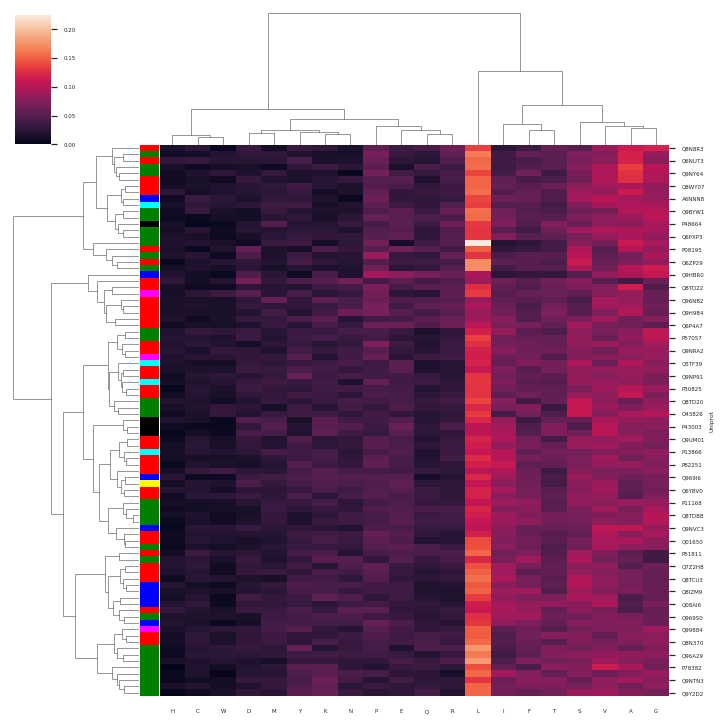

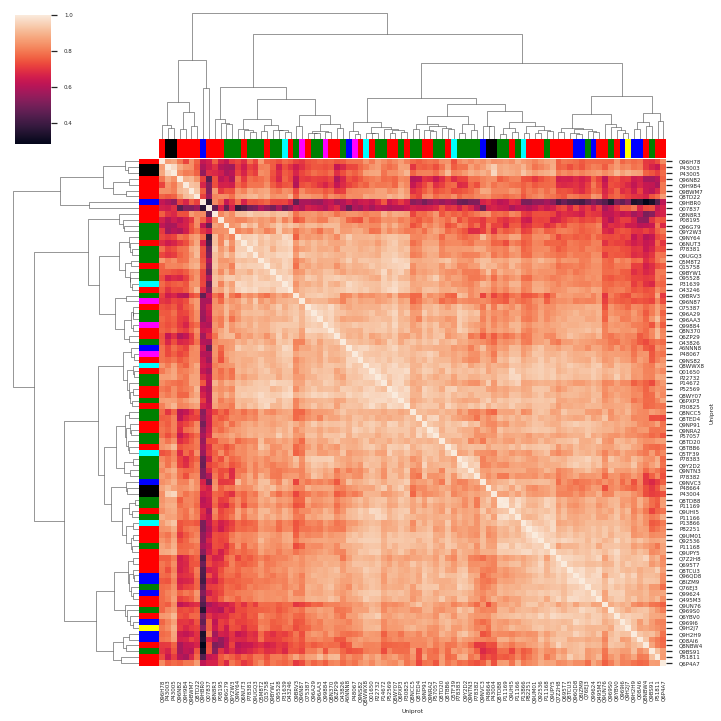

In [11]:
df_features = pd.read_table(f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0)
df_labels = pd.read_table(f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0)

labels_unique = df_labels.labels.unique()
colors = ["red", "green", "blue", "yellow", "magenta", "cyan", "black"]
colors_dict = {labels_unique[i]: colors[i] for i in range(len(labels_unique))}
print(colors_dict)
colors_labels = [colors_dict[label] for label in df_labels.labels]

sns.set(font_scale=0.5)
sns.clustermap(
    data=df_features,
    xticklabels=df_features.columns,
    # yticklabels=None,
    row_colors=colors_labels,
    method="ward",
)
sns.set(font_scale=1)
plt.show()

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

sns.set(font_scale=0.5)
sns.clustermap(
    data=df_features.T.corr(),
    xticklabels=df_features.index,
    yticklabels=df_features.index,
    row_colors=colors_labels,
    col_colors=colors_labels,
    method="ward",
)
sns.set(font_scale=1)
plt.show()

### Which proteins show the low correlation?

- SLC38A10: Golgi apparatus according to GO. Putative sodium-dependent amino acid/proton antiporter.
- SLC3A1: The only transporter with TCDB class 8 in the dataset: Accessory Factors in Transport. Location (GO): Extracellular region or secreted

These are probably two outliers I should remove.

In [12]:
df_annotations.loc[["Q9HBR0","Q07837"]]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9HBR0,Amino-acid transport;Ion transport;Sodium tran...,Membrane;Transmembrane,Transport,SLC38A10 PP1744,Putative sodium-coupled neutral amino acid tra...,2.A.18.6.16,9606,MTAAAASNWGLITNIVNSIVGVSVLTMPFCFKQCGIVLGALLLVFC...
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,9606,MAEDKSKRDSIEMSMKGCQTNNGFVHNEDILEQTPDPGSSTDNLKH...


### TCDB IDs in Datensatz

Other than RBAT, there are only two proteins without a TCDB class:

In [13]:
df_annotations.fillna("Nan").tcdb_id.apply(lambda s: s[0:3]).value_counts()

2.A    84
Nan     2
8.A     1
Name: tcdb_id, dtype: int64

Again, it's two of the SFXN proteins.

- SFXN3: Mitochondrial serine transporter
- SFXN5: Probably transports citrate

In [14]:
df_annotations[df_annotations.tcdb_id.isnull()]

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,sequence
Uniprot,,,,,,,,
Q9BWM7,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN3,Sideroflexin-3,NaN,9606,MGELPLDINIQEPRWDQSTFLGRARHFFTVTDPRNLLLSGAQLEAS...
Q8TD22,Amino-acid transport,Membrane;Mitochondrion;Transmembrane,Transport,SFXN5,Sideroflexin-5,NaN,9606,MADTATTASAAAASAASASSDAPPFQLGKPRFQQTSFYGRFRHFLD...


### 3.3 Korrelation der Features



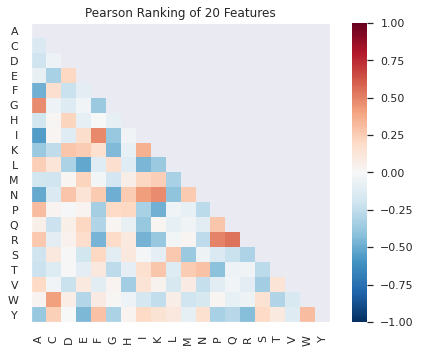

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [15]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
r2d = Rank2D(algorithm="pearson")
r2d.fit_transform(df_aac, df_labels.labels)
r2d.show()

#### Nur AA transporter

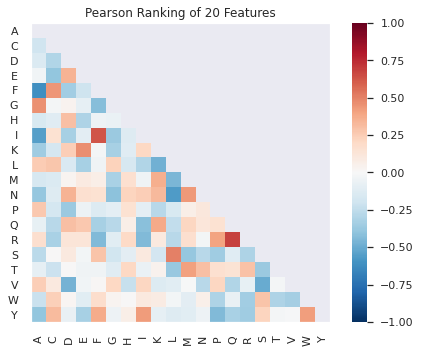

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [16]:
mask_amino = df_labels.labels == "Amino-acid transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_amino], df_labels.loc[mask_amino].labels)
r2d.show()

#### Nur Sugar transporter

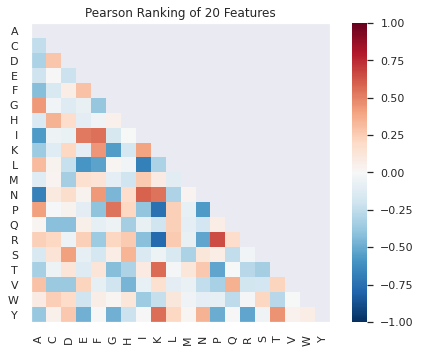

<AxesSubplot:title={'center':'Pearson Ranking of 20 Features'}>

In [17]:
mask_sugar = df_labels.labels == "Sugar transport"
r2d = Rank2D(algorithm='pearson')
r2d.fit_transform(df_aac.loc[mask_sugar], df_labels.loc[mask_sugar].labels)
r2d.show()

### 3.4 Folgen die AAC Features einer Normalverteilung?


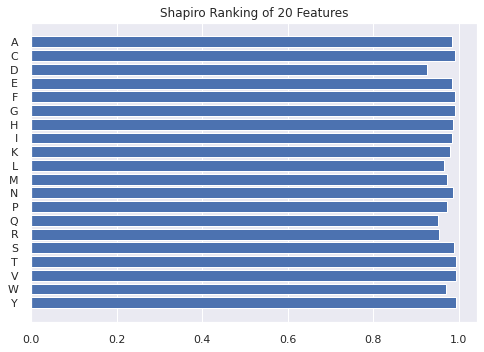

<AxesSubplot:title={'center':'Shapiro Ranking of 20 Features'}>

In [18]:
df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
r2d = Rank1D(algorithm="shapiro")
r2d.fit_transform(df_aac, df_labels.labels)
r2d.show()


#### Verteilung von D


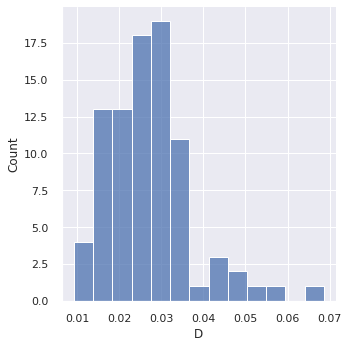

In [19]:
import seaborn as sns
sns.displot(df_aac.D)

#### Proteine mit hohen D

- There seems to be one protein that does not fit in the normal distribution
- Again, it's the accessory factor RBAT

In [20]:
df_annotations.loc[df_aac[df_aac.D > 0.06].index].join(df_aac.D, how="left").drop("sequence", axis=1)

,keywords_transport,keywords_location,keywords_transport_related,gene_names,protein_names,tcdb_id,organism_id,D
Uniprot,,,,,,,,
Q07837,Amino-acid transport,Membrane;Transmembrane,Transport,SLC3A1 RBAT,Neutral and basic amino acid transport protein...,8.A.9.1.2,9606,0.068613


### 3.5 Feature importance


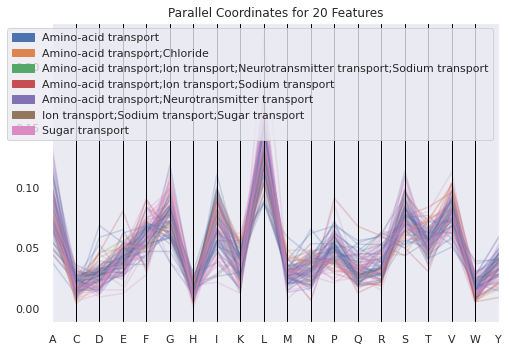

<AxesSubplot:>

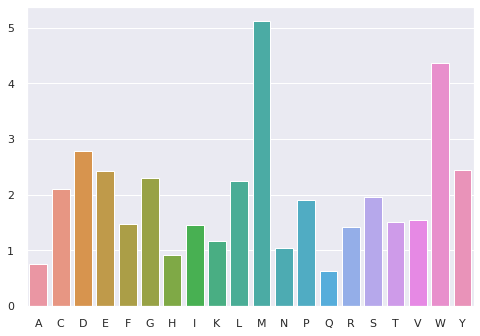

In [21]:
pc = ParallelCoordinates()

pc.fit_transform(df_aac, df_labels.labels)
pc.show()

skb = SelectKBest(k=20)
skb.fit(df_aac, df_labels.labels)
sns.barplot(x=df_aac.columns, y=skb.scores_)


### 3.6 Boxplots alle, amino, sugar

- Hier sieht man Unterschiede im Mittelwert bei den guten Features, allerdings auch Überschneidung
- Die guten Features zusammen könnten im 5-dimensionalen Raum für die guten SVM Ergebnisse sorgen.

<AxesSubplot:>

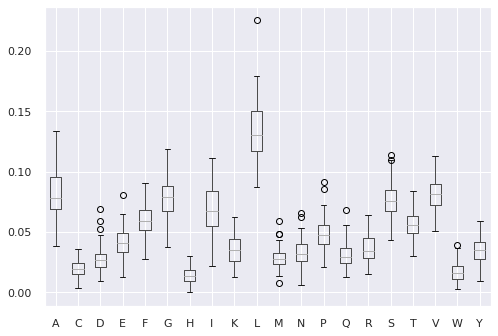

In [22]:
df_aac.boxplot()

<AxesSubplot:>

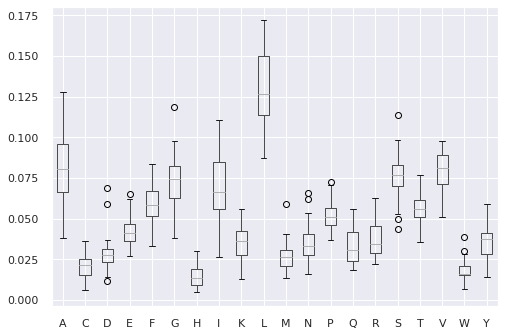

In [23]:
df_aac.loc[mask_amino].boxplot()

<AxesSubplot:>

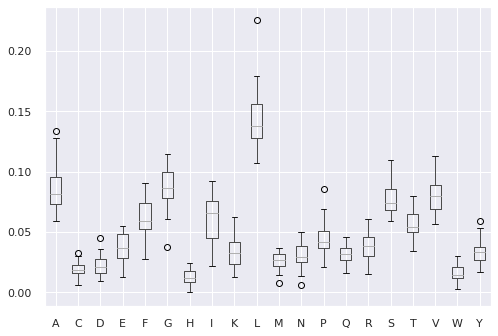

In [24]:
df_aac.loc[mask_sugar].boxplot()

### PCA Plots

Hier sind die PCA Plots, wegen denen ich die Analyse angefangen habe. Ich hatte mich gefragt, warum die SVM gut Ergebnisse liefert, obwohl der PCA plot so uneindeutig aussieht. 

Man sieht oben rechts wieder die Outliers mit hohem Prolin/Glutamat Anteil. 

**TODO sind das wirklich die gleichen?**

Bei dem 3D Plot sieht man, dass die Auftrennung schon etwas besser wird. 

Weiter unten wird sich zeigen, dass die lineare SVM erst im 3D Raum gute Scores liefert (f1>0.8).

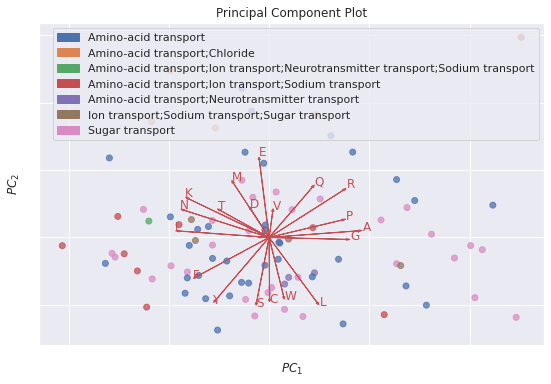

/home/ad/miniconda3/envs/subpred/lib/python3.9/site-packages/yellowbrick/features/pca.py:458: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self.fig.tight_layout()


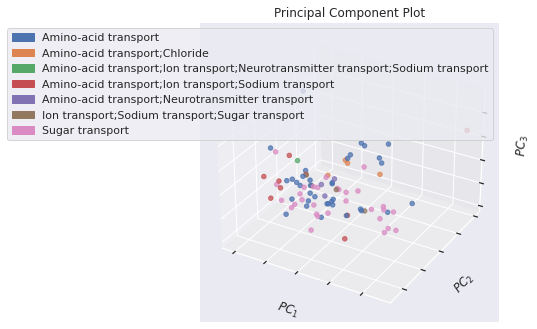

<Axes3DSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [25]:
from yellowbrick.features import PCA as PCAPlot

df_aac = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
le = LabelEncoder()
y = le.fit_transform(df_labels.labels.ravel())

pca_plot = PCAPlot(classes=le.classes_, scale=True, proj_features=True, features=df_aac.columns)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

pca_plot = PCAPlot(classes=le.classes_, scale=True, features=df_aac.columns, projection=3)
pca_plot.fit_transform(df_aac.to_numpy(), y)
pca_plot.show()

## Model training 

### Test: Does removing the outliers improve classification results?

- Yes, there is a small improvement

##### With outliers

In [26]:
create_dataset(
    keywords_substrate_filter = ["Amino-acid transport","Sugar transport"],
    keywords_component_filter = ["Transmembrane"],
    keywords_transport_filter = ["Transport"],
    input_file = "../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate = "integrate",
    verbose = True,
    tax_ids_filter = [TAX_ID],
    output_tsv = f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta = f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log = LOG_FILE,
)
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_labels.tsv"
)
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    feature_type="aac",
)

df_aac_outliers = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0
)
df_labels_outliers = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
print(df_labels_outliers.labels.value_counts())
X_outliers = df_aac_outliers.to_numpy()
label_encoder = LabelEncoder()
y_outliers = label_encoder.fit_transform(df_labels_outliers.to_numpy().ravel())

gsearch = GridSearchCV(
    estimator=make_pipeline(
        StandardScaler(),
        SVC(max_iter=1e6),
    ),
    param_grid={
        "svc__class_weight": ["balanced", None],
        "svc__C": [0.1, 1, 10],
        "svc__gamma": ["scale", 0.1, 0.01, 0.001],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)
gsearch.fit(X_outliers, y_outliers)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


Amino-acid transport    53
Sugar transport         34
Name: labels, dtype: int64
{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
0.6919336219336218


##### Without outliers

In [27]:
create_dataset(
    keywords_substrate_filter=["Amino-acid transport", "Sugar transport"],
    keywords_component_filter=["Transmembrane"],
    keywords_transport_filter=["Transport"],
    input_file="../data/raw/swissprot/uniprot-reviewed_yes.tab.gz",
    multi_substrate="integrate",
    verbose=True,
    outliers=["Q9HBR0", "Q07837"],
    tax_ids_filter=[TAX_ID],
    output_tsv=f"../data/datasets/{ORGANISM}_amino_sugar.tsv",
    output_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_log=LOG_FILE,
)
fasta_to_labels(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_labels.tsv",
)
calculate_composition_feature(
    input_fasta=f"../data/datasets/{ORGANISM}_amino_sugar.fasta",
    output_tsv=f"../data/features/{ORGANISM}_amino_sugar_aac.tsv",
    feature_type="aac",
)

df_aac = pd.read_table(f"../data/features/{ORGANISM}_amino_sugar_aac.tsv", index_col=0)
df_labels = pd.read_table(
    f"../data/features/{ORGANISM}_amino_sugar_labels.tsv", index_col=0
)
print(df_labels.labels.value_counts())
X = df_aac.to_numpy()
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_labels.to_numpy().ravel())

gsearch = GridSearchCV(
    estimator=make_pipeline(StandardScaler(), SVC(max_iter=1e6),),
    param_grid={
        "svc__class_weight": ["balanced", None],
        "svc__C": [0.1, 1, 10, 100],
        "svc__gamma": ["scale", 0.1, 0.01, 0.001, 0.0001],
    },
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    return_train_score=True,
)
gsearch.fit(X, y)
print(gsearch.best_params_)
print(gsearch.best_score_)
best_estimator_svc = gsearch.best_estimator_


Amino-acid transport    51
Sugar transport         34
Name: labels, dtype: int64
{'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 0.01}
0.7036308278252013


## Note

It later became clear that removing the multi-substrate transporters improves performance